# Univariate Distribution Similarity

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ing-bank/probatus/blob/master/docs/tutorials/nb_distribution_statistics.ipynb)

There are many situations when you want to perform univariate distribution comparison of a given feature, e.g. stability of the feature over different months.

In order to do that, you can use statistical tests. In this tutorial we present how to easily do this using the `DistributionStatistics` class, and with the statistical tests directly.

Available tests:
- `'ES'`: Epps-Singleton
- `'KS'`: Kolmogorov-Smirnov
- `'PSI'`: Population Stability Index
- `'SW'`: Shapiro-Wilk
- `'AD'`: Anderson-Darling

Details on the available tests can be found [here](https://ing-bank.github.io/probatus/api/stat_tests.html#available-tests).

You can perform all these tests using a convenient wrapper class called `DistributionStatistics`.

In this tutorial we will focus on how to perform two useful tests: Population Stability Index (widely applied in banking industry) and Kolmogorov-Smirnov.

## Setup

In [1]:
%%capture
!pip install probatus

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from probatus.binning import AgglomerativeBucketer, SimpleBucketer, QuantileBucketer
from probatus.stat_tests import DistributionStatistics, psi, ks

Let's define some test distributions and visualize them. For these examples, we will use a normal distribution and a shifted version of the same distribution.

In [3]:
counts = 1000
np.random.seed(0)
d1 = pd.Series(np.random.normal(size=counts), name='feature_1')
d2 = pd.Series(np.random.normal(loc=0.5, size=counts), name='feature_1')

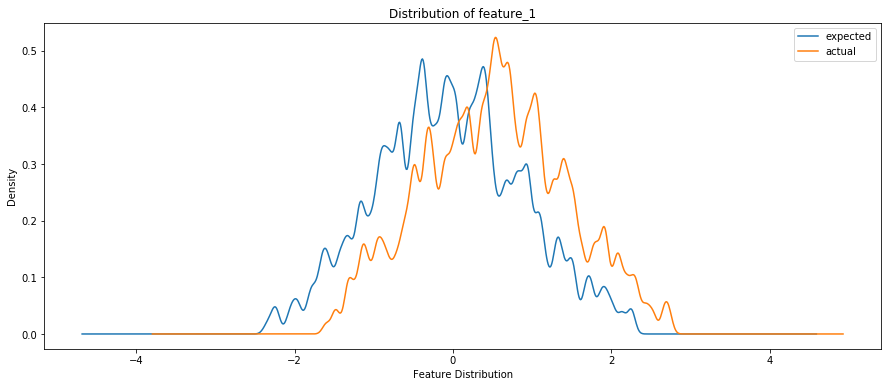

In [4]:
from probatus.utils.plots import plot_distributions_of_feature

feature_distributions = [d1, d2]
sample_names = ['expected', 'actual']
plot_distributions_of_feature(feature_distributions, sample_names=sample_names, plot_perc_outliers_removed=0.01)

### Binning - QuantileBucketer

To visualize the data, we will bin the data using a quantile bucketer, available in the `probatus.binning` module.

Binning is used by all the `stats_tests` in order to group observations.

In [5]:
bins = 10
myBucketer = QuantileBucketer(bins)
d1_bincounts = myBucketer.fit_compute(d1)
d2_bincounts = myBucketer.compute(d2)

print("Bincounts for d1 and d2:")
print(d1_bincounts)
print(d2_bincounts)

Bincounts for d1 and d2:
[100 100 100 100 100 100 100 100 100 100]
[ 25  62  50  68  76  90  84 169 149 227]


Let's plot the distribution for which we will calculate the statistics.

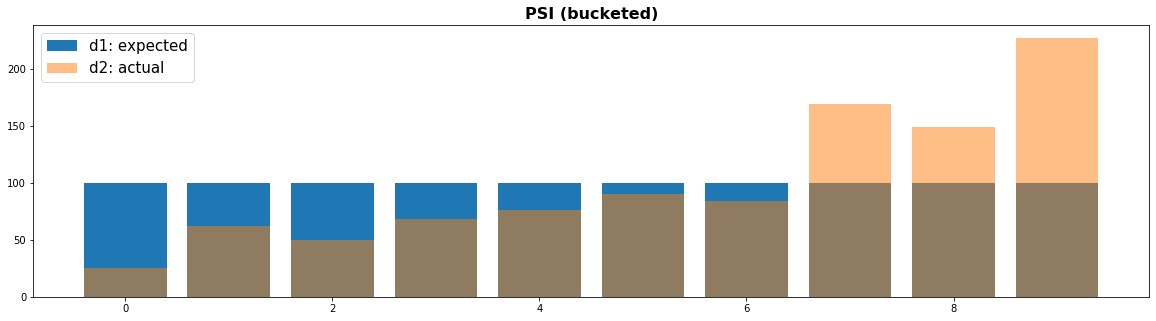

In [6]:
plt.figure(figsize=(20,5))
plt.bar(range(0, len(d1_bincounts)), d1_bincounts, label='d1: expected')
plt.bar(range(0, len(d2_bincounts)), d2_bincounts, label='d2: actual', alpha=0.5)
plt.title('PSI (bucketed)', fontsize=16, fontweight='bold')
plt.legend(fontsize=15)
plt.show()

By visualizing the bins, we can already notice that the distributions are different.

Let's use the statistical test to prove that.

## PSI - Population Stability Index
The population stability index ([Karakoulas, 2004](https://cms.rmau.org/uploadedFiles/Credit_Risk/Library/RMA_Journal/Other_Topics_(1998_to_present)/Empirical%20Validation%20of%20Retail%20Credit-Scoring%20Models.pdf)) has long been used to evaluate distribution similarity in the banking industry, while developing credit decision models.

In `probatus` we have implemented the PSI according to [Yurdakul 2018](https://scholarworks.wmich.edu/cgi/viewcontent.cgi?article=4249&context=dissertations), which derives a p-value, based on the hard to interpret PSI statistic. Using the p-value is a more reliable choice, because the banking industry-standard PSI critical values of 0.1 and 0.25 are unreliable heuristics as there is a strong dependency on sample sizes and number of bins. Aside from these heuristics, the PSI value is not easily interpretable in the context of common statistical frameworks (like a p-value or confidence levels).

In [7]:
psi_value, p_value = psi(d1_bincounts, d2_bincounts, verbose=True)


PSI = 0.33942407655561885

PSI: Critical values defined according to de facto industry standard:
PSI > 0.25: Significant distribution change; investigate.

PSI: Critical values defined according to Yurdakul (2018):
99.9% confident distributions have changed.


Based on the above test, the distribution between the two samples significantly differ.
Not only is the PSI statistic above the commonly used critical value, but also the p-value shows a very high confidence.

## PSI with DistributionStatistics 

Using the `DistributionStatistics` class one can apply the above test without the need to manually perform the binning. We initialize a `DistributionStatistics` instance with the desired test, binning_strategy (or choose `"default"` to choose the test's most appropriate binning strategy) and the number of bins. Then we start the test with the unbinned values as input.

In [8]:
distribution_test = DistributionStatistics("psi", binning_strategy="default", bin_count=10)
psi_value, p_value = distribution_test.compute(d1, d2, verbose=True)


PSI = 0.33942407655561885

PSI: Critical values defined according to de facto industry standard:
PSI > 0.25: Significant distribution change; investigate.

PSI: Critical values defined according to Yurdakul (2018):
99.9% confident distributions have changed.


## KS: Kolmogorov-Smirnov with DistributionStatistics
The Kolmogorov-Smirnov test compares two distributions by calculating the maximum difference of the two samples' distribution functions, as illustrated by the black arrow in the following figure. The KS test is available in `probatus.stat_tests.ks`.

<img align="middle" src="../img/KS2_Example.png" alt="Example of the Kolmogorov-Smirnov value" width="400" height="400">

The main advantage of this method is its sensitivity to differences in both location and shape of the empirical cumulative distribution functions of the two samples.

The main disadvantages are that: it works for continuous distributions (unless modified, e.g. see ([Jeng 2006](https://bmcmedresmethodol.biomedcentral.com/track/pdf/10.1186/1471-2288-6-45))); in large samples, small and unimportant differences can be statistically significant ([Taplin & Hunt 2019](https://www.mdpi.com/2227-9091/7/2/53/pdf)); and finally in small samples, large and important differences can be statistically insignificant ([Taplin & Hunt 2019](https://www.mdpi.com/2227-9091/7/2/53/pdf)).

As before, using the test requires you to perform the binning beforehand

In [9]:
k_value, p_value = ks(d1, d2, verbose=True)


KS: pvalue = 2.104700973377179e-27

KS: Null hypothesis rejected with 99% confidence. Distributions very different.


Again, we can also choose to combine the binning and the statistical test using the `DistributionStatistics` class.

In [10]:
distribution_test = DistributionStatistics("ks", binning_strategy=None)
ks_value, p_value = distribution_test.compute(d1, d2, verbose=True)


KS: pvalue = 2.104700973377179e-27

KS: Null hypothesis rejected with 99% confidence. Distributions very different.


## AutoDist

In [11]:
from probatus.stat_tests import AutoDist

Multiple statistics can automatically be calculated using `AutoDist`. To show this, let's create two new dataframes with two features each.

In [12]:
size, n_features = 100, 2

df1 = pd.DataFrame(np.random.normal(size=(size, n_features)), columns=[f'feat_{x}' for x in range(n_features)])
df2 = pd.DataFrame(np.random.normal(size=(size, n_features)), columns=[f'feat_{x}' for x in range(n_features)])

We can now specify the statistical tests we want to perform and the binning strategies to perform. We can also set both of these variables to `'all'` or binning strategies to `'default'` to use the default binning strategy for every chosen statistical test.

In [13]:
statistical_tests = ["KS", "PSI"]
binning_strategies = "default"

Let's compute the statistics and their p_values:

In [14]:
myAutoDist = AutoDist(statistical_tests=statistical_tests, binning_strategies=binning_strategies, bin_count=10)
myAutoDist.compute(df1, df2)

100%|██████████| 2/2 [00:00<00:00, 139.13it/s]


,column,p_value_KS_no_bucketing_0,p_value_PSI_quantilebucketer_10,statistic_KS_no_bucketing_0,statistic_PSI_quantilebucketer_10
0,feat_0,0.815415,0.443244,0.09,0.192113
1,feat_1,0.281942,0.010922,0.14,0.374575
